# Overlaid Arrow Image Generator Notebook

To support training and inference of the arrow detector, we want to create a pipeline to generate images with a variety of different arrow PNGs randomnly overlaid onto medical images of varying modalities.

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os

In [2]:
def resize_to_width(image_rgb, target_w=1024, interpolation=cv2.INTER_LINEAR):
    """
    Resize an RGB image to the specified width while preserving aspect ratio.

    Parameters:
    - image_rgb: np.ndarray (H,W,3) in RGB
    - target_w: int target width (default: 1024)
    - interpolation: OpenCV interpolation method

    Returns:
    - resized RGB image with width == target_w
    """
    h, w = image_rgb.shape[:2]
    if w == target_w:
        return image_rgb
    target_h = int(round(h * (target_w / w)))
    return cv2.resize(image_rgb, (target_w, target_h), interpolation=interpolation)

In [3]:
def preprocess_arrow(arrow_path, rotation_angle=0, scale_x=None, scale_y=None, scale_master=None, color=None):
    """
    Preprocess arrow PNG by rotating, scaling, and coloring it.

    Parameters:
    -----------
    arrow_image : string
        Filepath of transparent background arrow image located in arrow-pngs folder
    rotation_angle : float
        Rotation angle in degrees (0 = pointing right, 90 = pointing up, -90 = pointing down, 180 = pointing left)
    scale_x : float, optional
        Horizontal scale factor (default: random between 0.2 and 1.0)
    scale_y : float, optional
        Vertical scale factor (default: random between 0.2 and 1.0)
    color : tuple, optional
        RGB color tuple (0-255) to tint the arrow (default: random color)
    
    Returns:
    --------
    arrow_rgb : np.ndarray
        Rotated and scaled arrow image in RGB format
    alpha : np.ndarray
        Alpha channel for the rotated arrow
    tip_local : tuple
        (x, y) coordinates of the arrow tip in the rotated image
    tail_local : tuple
        (x, y) coordinates of the arrow tail in the rotated image
    bbox_local : tuple
        (x_min, y_min, x_max, y_max) of non-zero alpha in rotated image coords
    """
    arrow_image = cv2.imread(arrow_path, cv2.IMREAD_UNCHANGED)

    # Generate random scale factors if not provided
    if scale_master is None:
        scale_master = random.uniform(0.4, 1.2)
    if scale_x is None:
        scale_x = random.uniform(0.6, 1.4) * scale_master
    if scale_y is None:
        scale_y = random.uniform(0.6, 1.4) * scale_master

    # Generate fully independent RGB if not provided
    if color is None:
        color = tuple(np.random.randint(0, 256, size=3).tolist())

    # Extract BGR and alpha from arrow image
    if arrow_image.shape[2] == 4:
        arrow_bgr = arrow_image[:, :, :3]
        alpha = arrow_image[:, :, 3] / 255.0
    else:
        arrow_bgr = arrow_image
        alpha = np.ones((arrow_image.shape[0], arrow_image.shape[1]))

    # Convert arrow from BGR to RGB
    arrow_rgb = cv2.cvtColor(arrow_bgr, cv2.COLOR_BGR2RGB)

    # Recolor arrow uniformly using the alpha mask so each channel is independent
    mask = alpha > 0
    arrow_rgb[...] = 0
    arrow_rgb[mask] = color

    # Apply random scaling (independently for x and y)
    h, w = arrow_rgb.shape[:2]
    new_w = int(w * scale_x)
    new_h = int(h * scale_y)

    if new_w > 0 and new_h > 0:
        arrow_rgb = cv2.resize(arrow_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        alpha = cv2.resize(alpha, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Original arrow dimensions and tip/tail positions (before rotation)
    # Tip is in the middle of the right side, tail on the left
    original_tip_local = (arrow_rgb.shape[1], arrow_rgb.shape[0] // 2)
    original_tail_local = (0, arrow_rgb.shape[0] // 2)

    # If no rotation needed, return as-is
    if rotation_angle == 0:
        # Compute bbox on current alpha
        ys, xs = np.nonzero(alpha > 0)
        if len(xs) == 0 or len(ys) == 0:
            bbox_local = (0, 0, 0, 0)
        else:
            bbox_local = (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))
        return arrow_rgb, alpha, original_tip_local, original_tail_local, bbox_local

    # Get the center of rotation (the tip point)
    h, w = arrow_rgb.shape[:2]
    center = original_tip_local

    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Calculate new canvas size to fit the rotated image
    # Get the four corners of the original image
    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [0, h, 1],
        [w, h, 1]
    ]).T

    # Transform corners to find new bounding box
    transformed = rotation_matrix @ corners
    x_coords = transformed[0, :]
    y_coords = transformed[1, :]

    x_min = int(np.floor(x_coords.min()))
    x_max = int(np.ceil(x_coords.max()))
    y_min = int(np.floor(y_coords.min()))
    y_max = int(np.ceil(y_coords.max()))

    new_w = x_max - x_min
    new_h = y_max - y_min

    # Adjust rotation matrix to account for the new canvas position
    rotation_matrix[0, 2] -= x_min
    rotation_matrix[1, 2] -= y_min

    # Rotate the arrow image with the expanded canvas
    arrow_rgb_rotated = cv2.warpAffine(arrow_rgb, rotation_matrix, (new_w, new_h), 
                                        borderMode=cv2.BORDER_CONSTANT, 
                                        borderValue=(0, 0, 0))

    # Rotate the alpha channel
    alpha_rotated = cv2.warpAffine(alpha, rotation_matrix, (new_w, new_h), 
                                     borderMode=cv2.BORDER_CONSTANT, 
                                     borderValue=0)

    # Transform the tail coordinates using the adjusted rotation matrix
    tail_point = np.array([original_tail_local[0], original_tail_local[1], 1]).reshape(3, 1)
    if arrow_path.endswith('arrow7.png'):
        tail_point[0][0] += 80 * scale_x

    tail_rotated = rotation_matrix @ tail_point
    tail_local_rotated = (int(round(tail_rotated[0, 0])), int(round(tail_rotated[1, 0])))

    # Transform the tip coordinates
    tip_point = np.array([original_tip_local[0], original_tip_local[1], 1]).reshape(3, 1)
    tip_rotated = rotation_matrix @ tip_point
    tip_local_rotated = (int(round(tip_rotated[0, 0])), int(round(tip_rotated[1, 0])))

    # Compute tight bbox around non-zero alpha
    ys, xs = np.nonzero(alpha_rotated > 0)
    if len(xs) == 0 or len(ys) == 0:
        bbox_local = (0, 0, 0, 0)
    else:
        bbox_local = (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))
    
    return arrow_rgb_rotated, alpha_rotated, tip_local_rotated, tail_local_rotated, bbox_local


In [4]:
def overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=1, num_arrows=2, tip_margin_ratio=0.05):
    """
    Overlay multiple randomly preprocessed arrows onto a base RGB image.

    Returns:
    - output_rgb: np.ndarray (H,W,3) RGB image with arrows overlaid
    - tips: list of (x, y) tip locations on output image
    - tails: list of (x, y) tail locations on output image
    - bboxes: list of (x_min, y_min, x_max, y_max) for each overlaid arrow
    """
    base_h, base_w = base_image_rgb.shape[:2]
    margin_w = int(tip_margin_ratio * base_w)
    margin_h = int(tip_margin_ratio * base_h)

    # Collect arrow PNGs
    arrow_files = [f for f in os.listdir(arrow_dir) if f.lower().endswith(".png")]
    if not arrow_files:
        raise ValueError(f"No PNG files found in {arrow_dir}")

    def intersect_ranges(current, new_ranges):
        merged = []
        for a_start, a_end in current:
            for b_start, b_end in new_ranges:
                start = max(a_start, b_start)
                end = min(a_end, b_end)
                if start < end:
                    merged.append((start, end))
        return merged

    output = base_image_rgb.copy()
    tips = []
    tails = []
    bboxes = []

    for _ in range(num_arrows):
        # Random tip position within margins
        tip_x = random.randint(margin_w, max(margin_w, base_w - margin_w))
        tip_y = random.randint(margin_h, max(margin_h, base_h - margin_h))

        # Angular constraints so tail stays away from nearby edges
        allowed = [(0.0, 360.0)]
        right_edge = tip_x >= 0.8 * base_w
        left_edge = tip_x <= 0.2 * base_w
        top_edge = tip_y <= 0.2 * base_h
        bottom_edge = tip_y >= 0.8 * base_h
        if right_edge:
            allowed = intersect_ranges(allowed, [(0, 90), (270, 360)])
        if left_edge:
            allowed = intersect_ranges(allowed, [(90, 270)])
        if top_edge:
            allowed = intersect_ranges(allowed, [(0, 180)])
        if bottom_edge:
            allowed = intersect_ranges(allowed, [(180, 360)])
        if not allowed:
            allowed = [(0.0, 360.0)]

        spans = [b - a for a, b in allowed]
        total_span = sum(spans)
        pick = random.uniform(0, total_span)
        cumulative = 0.0
        rotation_angle = 0.0
        for (a, b), span in zip(allowed, spans):
            if pick <= cumulative + span:
                rotation_angle = random.uniform(a, b)
                break
            cumulative += span

        # Pick random arrow and preprocess with constrained rotation
        arrow_path = os.path.join(arrow_dir, random.choice(arrow_files))
        arrow_rgb, alpha, tip_local, tail_local, bbox_local = preprocess_arrow(arrow_path, rotation_angle, scale_master=float(arrow_size)/4)

        # Arrow dimensions
        arrow_h, arrow_w = arrow_rgb.shape[:2]

        # Compute tail position in output coordinates
        tail_x = tip_x + (tail_local[0] - tip_local[0])
        tail_y = tip_y + (tail_local[1] - tip_local[1])

        # Placement (top-left of arrow on output) so tip aligns
        arrow_x = tip_x - tip_local[0]
        arrow_y = tip_y - tip_local[1]

        # Overlap region
        y_start = max(0, arrow_y)
        y_end = min(base_h, arrow_y + arrow_h)
        x_start = max(0, arrow_x)
        x_end = min(base_w, arrow_x + arrow_w)

        # Corresponding region in arrow image
        arrow_y_start = y_start - arrow_y
        arrow_y_end = y_end - arrow_y
        arrow_x_start = x_start - arrow_x
        arrow_x_end = x_end - arrow_x

        # Blend
        if (y_end > y_start) and (x_end > x_start):
            alpha_region = alpha[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end]
            for c in range(3):
                output[y_start:y_end, x_start:x_end, c] = (
                    output[y_start:y_end, x_start:x_end, c] * (1 - alpha_region) +
                    arrow_rgb[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end, c] * alpha_region
                )

        # Compute bbox in output coordinates by shifting local bbox
        bx0, by0, bx1, by1 = bbox_local
        bbox_out = (
            arrow_x + bx0,
            arrow_y + by0,
            arrow_x + bx1,
            arrow_y + by1
        )

        tips.append((tip_x, tip_y))
        tails.append((tail_x, tail_y))
        bboxes.append(bbox_out)

    return output, tips, tails, bboxes

## Demonstration on an Example Image

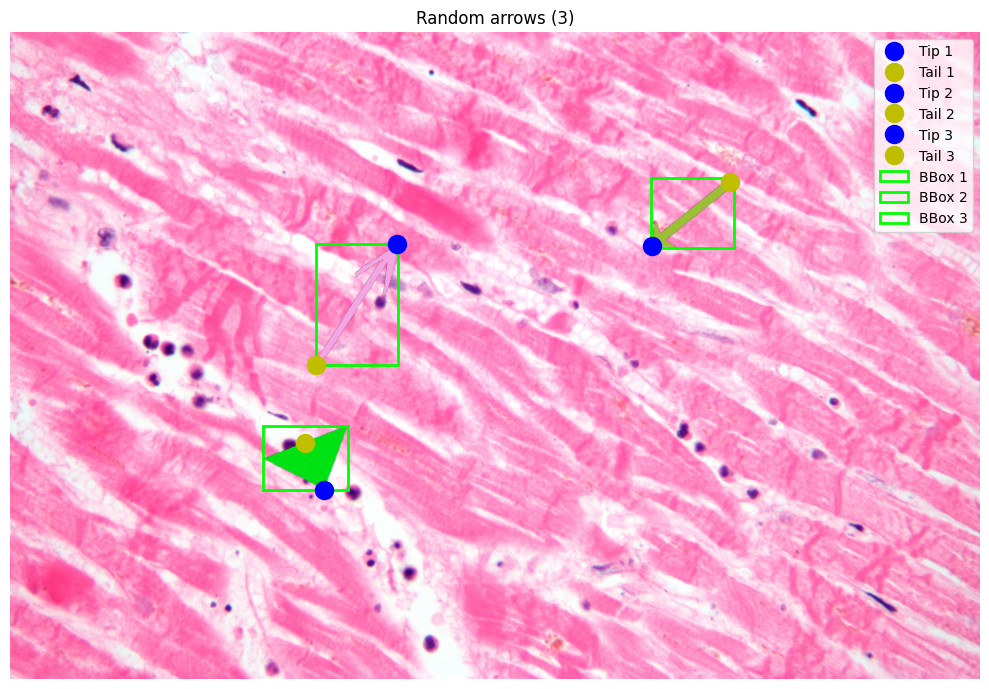

In [7]:
# Load base medical image
base_image_path = "medical-images/image1.jpg"
base_image = cv2.imread(base_image_path)
base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

# Resize to width 1024 while preserving aspect ratio
base_image_rgb = resize_to_width(base_image_rgb, target_w=1024)

# Overlay multiple random arrows using the new helper function
arrow_dir = "arrow-pngs"
output_rgb, tips, tails, bboxes = overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=0.8, num_arrows=3)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(output_rgb)
# Mark each tip and tail location
for i, (tip, tail) in enumerate(zip(tips, tails), start=1):
    plt.plot(tip[0], tip[1], 'bo', markersize=12, markeredgewidth=2, label=f'Tip {i}')
    plt.plot(tail[0], tail[1], 'yo', markersize=12, markeredgewidth=2, label=f'Tail {i}')

# Draw bounding boxes
for i, bbox in enumerate(bboxes, start=1):
    bx0, by0, bx1, by1 = bbox
    width = bx1 - bx0
    height = by1 - by0
    rect = patches.Rectangle((bx0, by0), width, height, linewidth=2, edgecolor='lime', facecolor='none', label=f'BBox {i}')
    plt.gca().add_patch(rect)

plt.title(f"Random arrows ({len(bboxes)})")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

## Dataset Generation

In [325]:
# Batch-generate overlaid arrow images for the dataset

medical_dir = "medical-images"
arrow_dir = "arrow-pngs"
output_dir = "dataset/images"
labels_dir = "dataset/labels"
num_arrows_per_image = 2  # adjust as desired
os.makedirs(output_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Collect medical images (common extensions)
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
medical_files = [f for f in os.listdir(medical_dir) if os.path.splitext(f)[1].lower() in valid_exts]
if not medical_files:
    raise ValueError(f"No images found in {medical_dir} with extensions {sorted(valid_exts)}")

print(f"Found {len(medical_files)} medical images. Writing outputs to '{output_dir}' and labels to '{labels_dir}'.")

for idx, img_name in enumerate(medical_files, start=1):
    base_image_path = os.path.join(medical_dir, img_name)
    base_image = cv2.imread(base_image_path)
    if base_image is None:
        print(f"[Skip] Could not read: {img_name}")
        continue
    base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

    # Resize to width 1024 while preserving aspect ratio
    base_image_rgb = resize_to_width(base_image_rgb, target_w=1024)

    base_h, base_w = base_image_rgb.shape[:2]

    # Use helper to overlay multiple random arrows on resized image
    output_rgb, tips, tails, bboxes = overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=0.8, num_arrows=num_arrows_per_image)

    # Save output image (preserve original extension)
    out_path = os.path.join(output_dir, img_name)
    output_bgr = cv2.cvtColor(output_rgb, cv2.COLOR_RGB2BGR)
    ok = cv2.imwrite(out_path, output_bgr)
    if not ok:
        print(f"[Warn] Failed to write: {out_path}")
        continue

    # Write YOLO pose-format labels (one line per arrow: class 0, bbox + tip/tail keypoints)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_name)
    with open(label_path, "w", encoding="utf-8") as f:
        for tip, tail, bbox in zip(tips, tails, bboxes):
            bx0, by0, bx1, by1 = bbox
            cx = (bx0 + bx1) / 2.0 / base_w
            cy = (by0 + by1) / 2.0 / base_h
            bw = (bx1 - bx0) / base_w
            bh = (by1 - by0) / base_h
            tip_xn, tip_yn = tip[0] / base_w, tip[1] / base_h
            tail_xn, tail_yn = tail[0] / base_w, tail[1] / base_h
            label_line = f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f} {tip_xn:.6f} {tip_yn:.6f} {tail_xn:.6f} {tail_yn:.6f}"
            f.write(label_line + "\n")

    print(f"Processed {idx}/{len(medical_files)} -> {out_path} | arrows={len(bboxes)} labels={label_path}")

Found 2 medical images. Writing outputs to 'dataset/images' and labels to 'dataset/labels'.
Processed 1/2 -> dataset/images/image1.jpg | arrows=2 labels=dataset/labels/image1.txt
Processed 2/2 -> dataset/images/image2.jpg | arrows=2 labels=dataset/labels/image2.txt
